# 0.환경설정

In [ ]:
# !pip install matplotlib

In [ ]:
# # 필요한 라이브러리를 설치합니다.
# !pip install timm

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd
import os

In [ ]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
drive.mount('/content/drive')

Mounted at /gdrive
Mounted at /content/drive


In [ ]:
# # 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
# !tar -xvf '/content/drive/MyDrive/AI Lab/CV 대회/data.tar.gz' -C '/content/drive/MyDrive/AI Lab/CV 대회/'

# 1.EDA 자동화 (텍스트 데이터)

## Pandas Profiling - 메타데이터 EDA

In [ ]:
# !pip install ydata-profiling

In [ ]:
# import pandas as pd
# from ydata_profiling import ProfileReport

# # train.csv 파일을 읽어옵니다.
# # train_df = pd.read_csv('/content/drive/MyDrive/AI Lab/CV 대회/data/train.csv')
# train_df = pd.read_csv('/content/drive/MyDrive/AI Lab/CV 대회/data/meta.csv')

# # 데이터 프레임에 대한 프로파일링 보고서 생성
# profile = ProfileReport(train_df, title="Train Data Profiling Report", explorative=True)

# # 프로파일링 보고서 보기
# profile.to_notebook_iframe()


## Dataprep.eda

In [ ]:
# !pip install dataprep

In [ ]:
# from dataprep.eda import create_report
# import pandas as pd

# # 데이터 불러오기
# df = pd.read_csv('/content/drive/MyDrive/AI Lab/CV 대회/data/meta.csv')

# # 보고서 생성
# create_report(df)

# 2.이미지 데이터 시각화 EDA

클래스별 이미지의 분포

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Attempt to load the CSV files with a different encoding
train_df = pd.read_csv('/content/drive/MyDrive/AI Lab/CV 대회/data/train.csv', encoding='latin1')
meta_df = pd.read_csv('/content/drive/MyDrive/AI Lab/CV 대회/data/meta.csv', encoding='latin1')

# Display the first few rows of the dataframes to understand their structure
train_df.head(), meta_df.head()

(                     ID  target
 0  002f99746285dfdd.jpg      16
 1  008ccd231e1fea5d.jpg      10
 2  008f5911bfda7695.jpg      10
 3  009235e4c9c07af5.jpg       4
 4  00b2f44967580c74.jpg      16,
    target                                         class_name
 0       0                                     account_number
 1       1  application_for_payment_of_pregnancy_medical_e...
 2       2                                      car_dashboard
 3       3            confirmation_of_admission_and_discharge
 4       4                                          diagnosis)

In [ ]:
# train 파일과 meta 파일을 target 기준으로 조인
merged_df = pd.merge(train_df, meta_df, on='target', how='left')

# 결과 확인
print(merged_df.head())

                     ID  target                  class_name
0  002f99746285dfdd.jpg      16  vehicle_registration_plate
1  008ccd231e1fea5d.jpg      10        payment_confirmation
2  008f5911bfda7695.jpg      10        payment_confirmation
3  009235e4c9c07af5.jpg       4                   diagnosis
4  00b2f44967580c74.jpg      16  vehicle_registration_plate


<ipython-input-12-43a8a8556e5c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


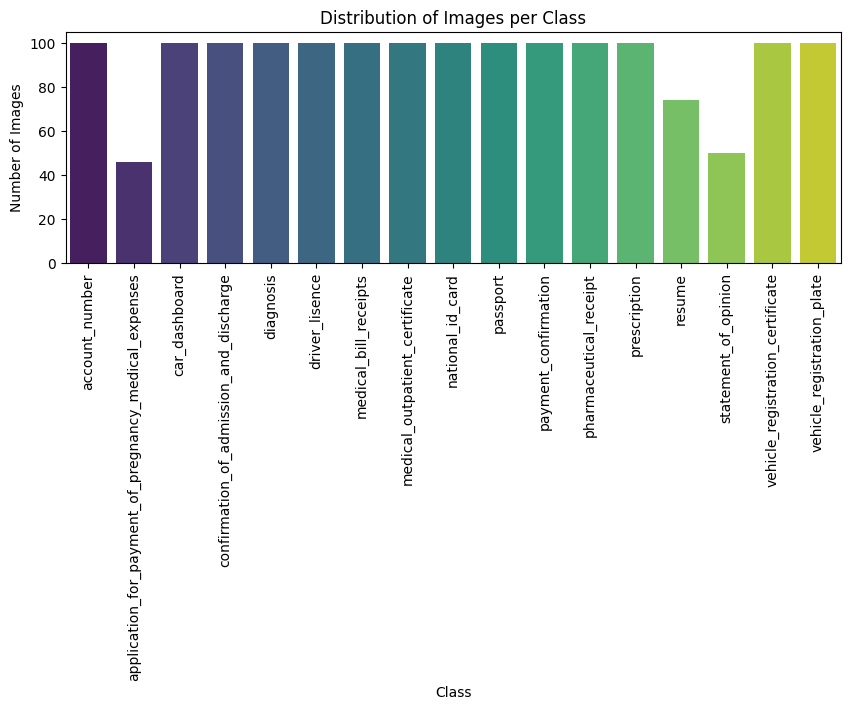

In [ ]:
# 클래스별 이미지 수 계산
class_distribution = merged_df['class_name'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 3))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=90)  # X축 레이블을 90도 회전
plt.show()


## a.Train data 샘플 시각화

각 클래스에서 몇 개의 샘플 이미지를 시각적으로 확인하여 데이터를 이해

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import os

# 각 클래스에서 샘플 이미지를 3개씩 표시
def plot_sample_images(train_df, class_names, num_samples=5, folder='/content/drive/MyDrive/AI Lab/CV 대회/data/train'):
    num_classes = train_df['target'].nunique()
    plt.figure(figsize=(20, num_classes * 5))

    for i in range(num_classes):
        class_samples = train_df[train_df['target'] == i].sample(num_samples)
        for j, (index, row) in enumerate(class_samples.iterrows()):
            img_path = os.path.join(folder, row['ID'])
            img = mpimg.imread(img_path)

            plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            if j == 0:
                plt.ylabel(f"Class: {class_names[i]}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# 클래스 이름을 딕셔너리로 변환
class_names_dict = meta_df.set_index('target')['class_name'].to_dict()

# 샘플 이미지 표시
plot_sample_images(train_df, class_names_dict)


Output hidden; open in https://colab.research.google.com to view.

## b. 이미지 크기 및 비율 분석

이미지 크기와 비율의 분포를 확인하여 이상치나 불일치를 식별

In [ ]:
# 이미지 크기를 얻는 함수
def get_image_sizes(df, image_dir, id_col='ID'):
    sizes = []
    for image_id in df[id_col]:
        img_path = os.path.join(image_dir, image_id)
        with Image.open(img_path) as img:
            sizes.append(img.size)
    return sizes

In [ ]:
# 이미지 디렉토리 경로 설정
image_dir = '/content/drive/MyDrive/AI Lab/CV 대회/data/train'  # 실제 이미지가 저장된 디렉토리로 변경 필요

# 이미지 크기 얻기
image_sizes = get_image_sizes(merged_df, image_dir)

# 분석을 위한 DataFrame으로 변환
size_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
size_df['class'] = merged_df['class_name']

<Figure size 1400x800 with 0 Axes>

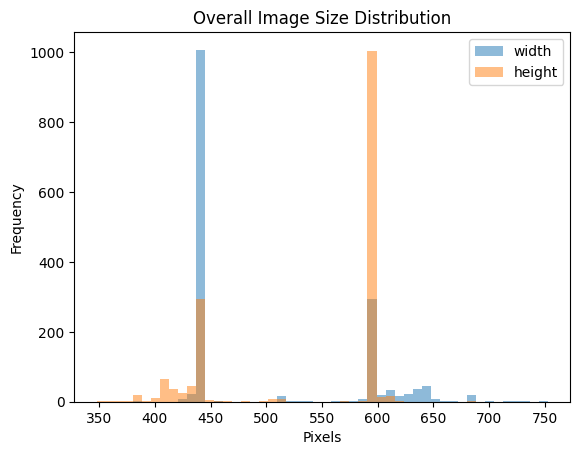

In [ ]:
# 크기 분포 플롯
plt.figure(figsize=(14, 8))
size_df.plot(kind='hist', y=['width', 'height'], bins=50, alpha=0.5, title='Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Overall Image Size Distribution')
plt.show()

<Figure size 2000x800 with 0 Axes>

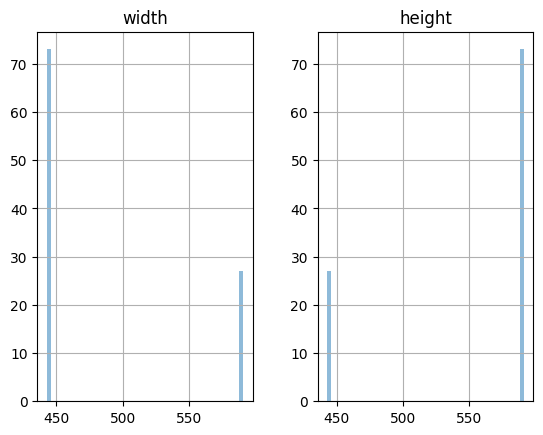

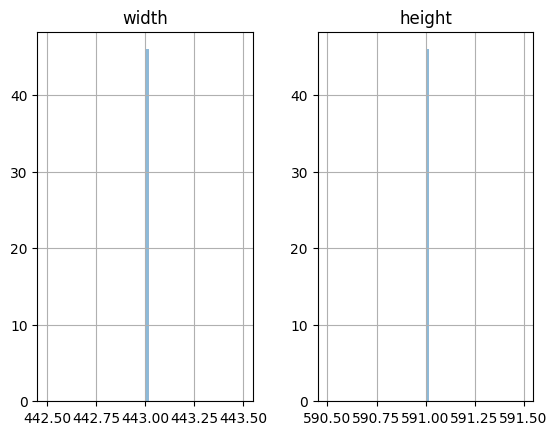

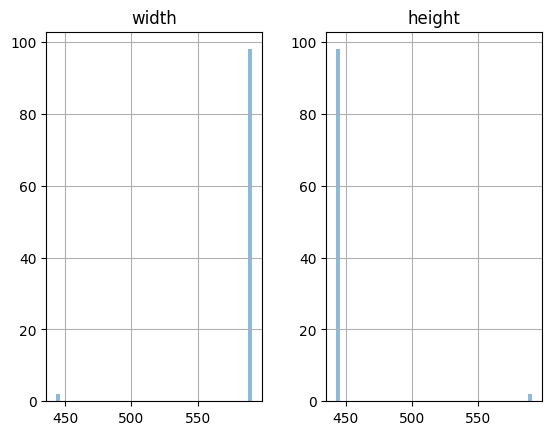

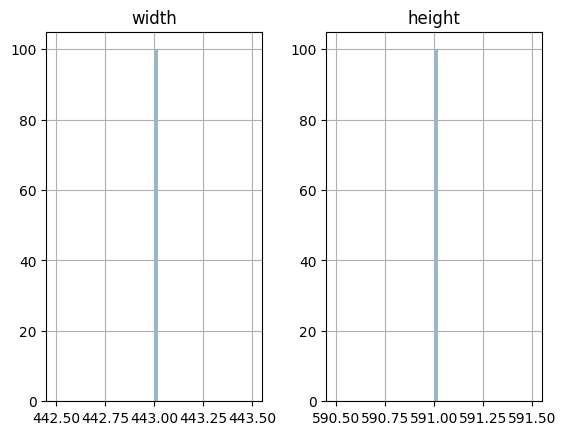

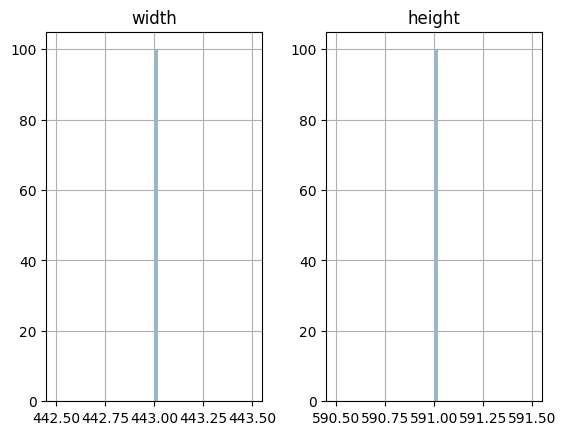

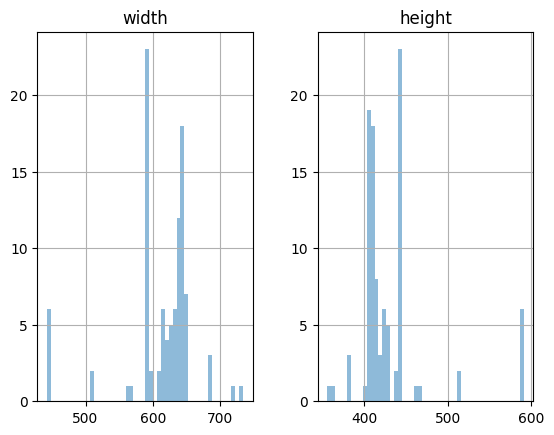

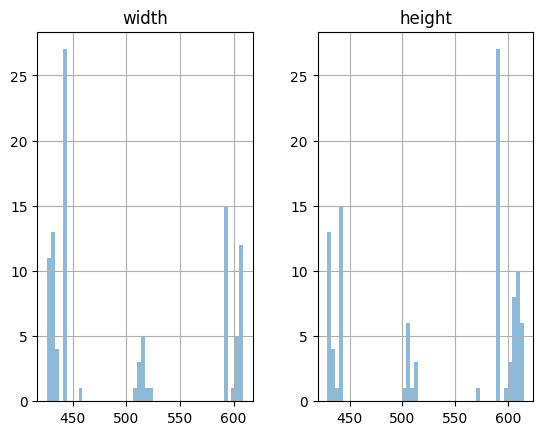

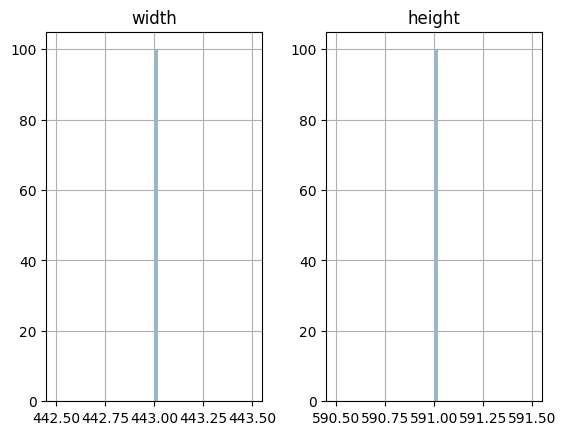

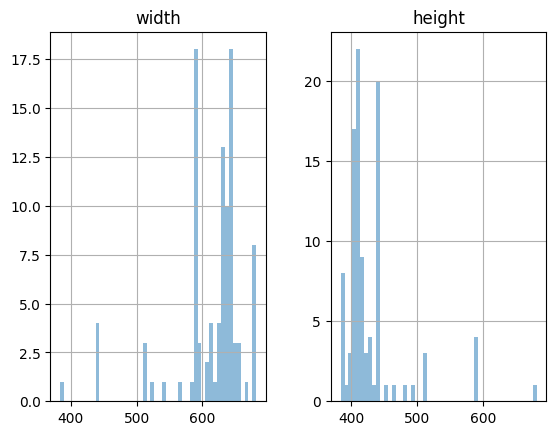

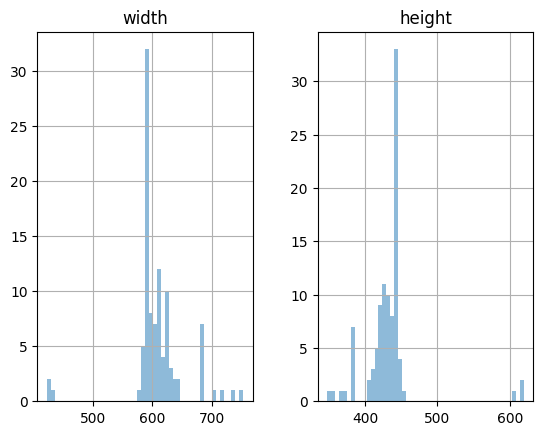

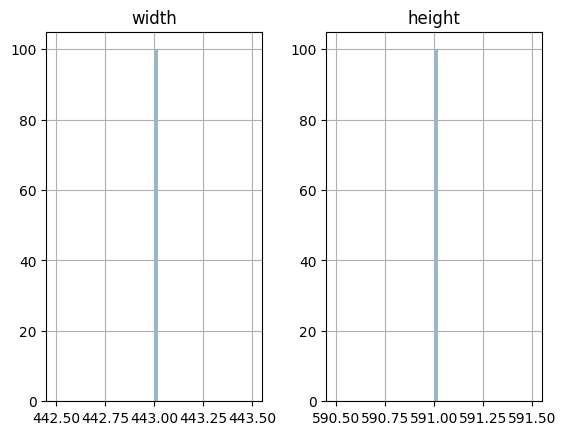

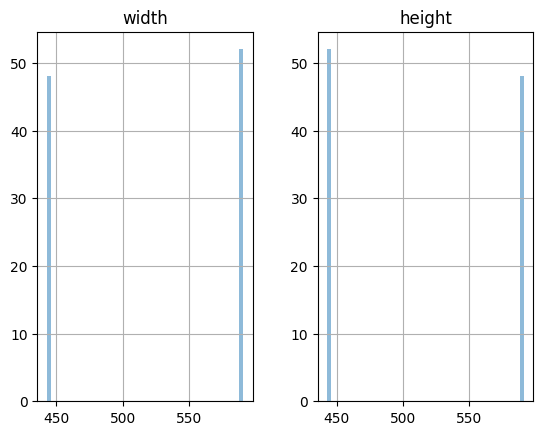

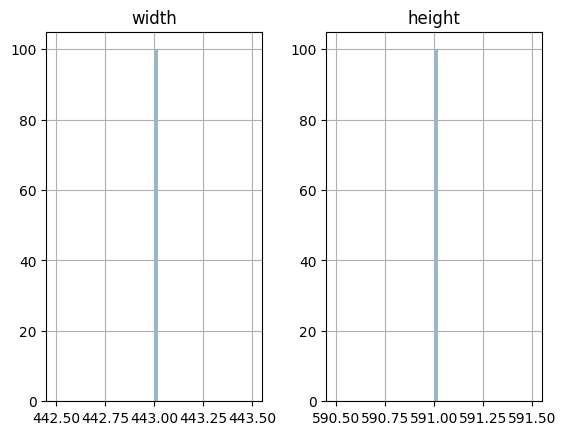

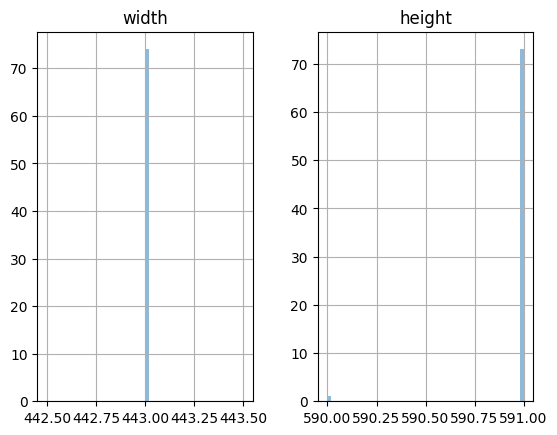

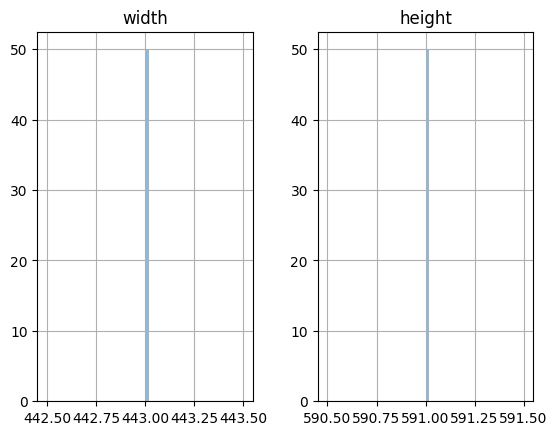

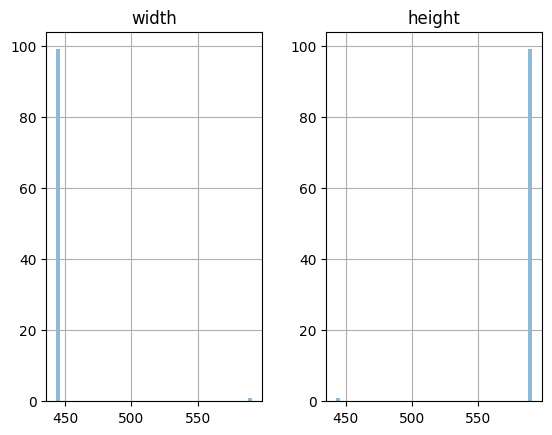

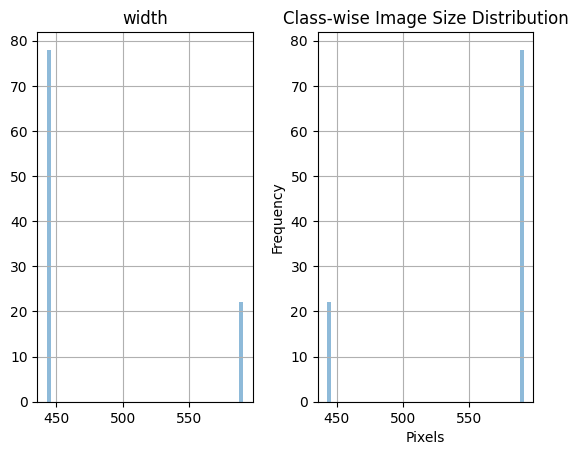

In [ ]:
# 클래스별 이미지 크기의 평균 계산
class_size_means = size_df.groupby('class').mean()

# 클래스별 이미지 크기 분포 플롯
plt.figure(figsize=(20, 8))
size_df.groupby('class').hist(bins=50, alpha=0.5)
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Class-wise Image Size Distribution')
plt.show()

In [ ]:
# 클래스별 이미지 크기의 평균 출력
print(class_size_means)

                                                     width      height
class                                                                 
account_number                                      482.96  551.030000
application_for_payment_of_pregnancy_medical_ex...  443.00  591.000000
car_dashboard                                       588.04  445.960000
confirmation_of_admission_and_discharge             443.00  591.000000
diagnosis                                           443.00  591.000000
driver_lisence                                      611.81  431.690000
medical_bill_receipts                               499.21  535.380000
medical_outpatient_certificate                      443.00  591.000000
national_id_card                                    613.43  430.960000
passport                                            608.98  432.560000
payment_confirmation                                443.00  591.000000
pharmaceutical_receipt                              519.96  514.040000
prescr

<Figure size 1400x800 with 0 Axes>

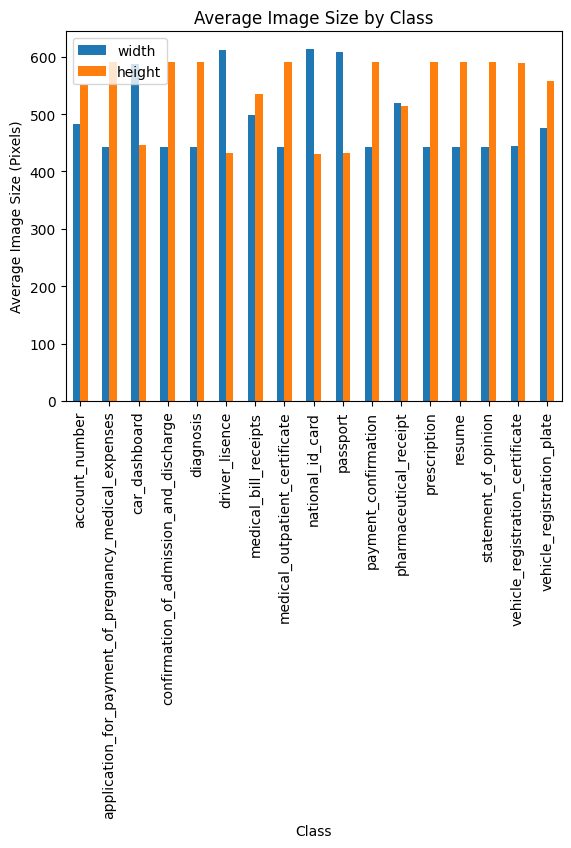

In [ ]:
# 클래스별 이미지 크기 평균을 하나의 그래프로 시각화
plt.figure(figsize=(14, 8))
class_size_means.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Average Image Size (Pixels)')
plt.title('Average Image Size by Class')
plt.xticks(rotation=90)
plt.show()

# 3.분포 관련 EDA

## a. 클래스 분포 분석

목표 클래스의 분포를 분석하여 클래스 불균형 여부를 확인

## b. 이미지 회전 및 플립 효과

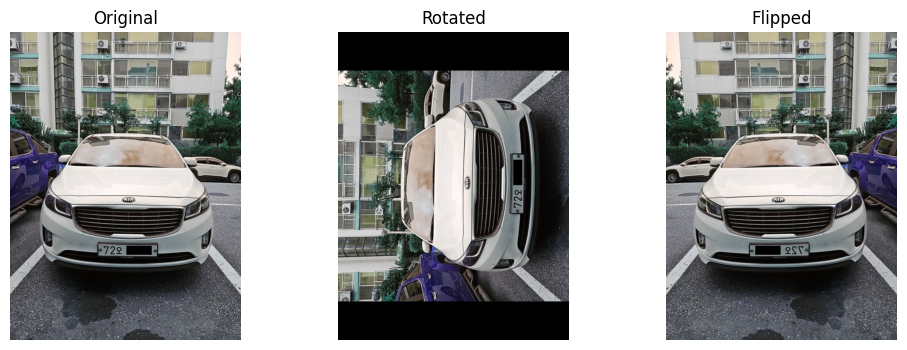

In [ ]:
# 변형 시각화
def visualize_transformations(img_path):
    img = Image.open(img_path)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # 원본
    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # 회전된 이미지
    rotated_img = img.rotate(90)
    axes[1].imshow(rotated_img)
    axes[1].set_title('Rotated')
    axes[1].axis('off')

    # 플립된 이미지
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    axes[2].imshow(flipped_img)
    axes[2].set_title('Flipped')
    axes[2].axis('off')

    plt.show()

# 예시로 단일 이미지 사용
visualize_transformations(os.path.join(image_dir, train_df.iloc[0]['ID']))
